In [1]:
# Import packages required
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets,transforms
import numpy as np
from torch.autograd import Variable

In [2]:
transformers=transforms.Compose([
                        transforms.Resize((32, 32)),
                        transforms.ToTensor()])

In [3]:
def dataloader(train_bsize, test_bsize):
    train_dataloader=torch.utils.data.DataLoader(torchvision.datasets.MNIST(root='data',train=True,download=True,
                            transform=transformers),batch_size=train_bsize, shuffle=True)
    test_dataloader=torch.utils.data.DataLoader(torchvision.datasets.MNIST(root='data',train=False,download=True,
                            transform= transformers),batch_size=test_bsize, shuffle=True)
    return (train_dataloader,test_dataloader)

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1=nn.Conv2d(1,6,5)
        self.conv2=nn.Conv2d(6,16,5)
        self.linear1=nn.Linear(16*5*5,100)
        self.linear2=nn.Linear(100,60)
        self.linear3=nn.Linear(60,10)
        
    def forward(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(x.size()[0], -1)
        x=self.linear1(x)
        x=F.leaky_relu(x)
        x=self.linear2(x)
        x=F.leaky_relu(x)
        x=self.linear3(x)
        return x

In [5]:
def sensitivity(model):
    c=0
    FNorm = 0
    for p in model.parameters():
        grad = 0.0
        if p.grad is not None:
            c+=1
            grad = p.grad
            FNorm += torch.linalg.norm(grad).numpy()
    return FNorm / c

In [6]:
def train_model(model,optimizer,loader,Floss):
    for b_index,(data,t) in enumerate(train_dataloader):
        #forward propagation
        optimizer.zero_grad()
        output=model(data)
        loss=Floss(output,t)
        loss.backward()
        optimizer.step()

In [7]:
def cal_loss_acc(model, loader, Floss):
    total_loss = 0
    loss_counter = 0
    correct_samples = 0
    total_samples = 0
    counter=0
    for batch in loader:
        data, target = batch
        pred = model(data)
        loss = Floss(pred, target)
        total_loss += loss
        counter+=1
        for i, outputTensor in enumerate(pred):
                if torch.argmax(outputTensor) == target[i]:
                    correct_samples += 1
                total_samples += 1
    return total_loss/counter, round(correct_samples/total_samples,3)

In [8]:
def compute(model,learning_rate):
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    epochs=10
    Floss = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs + 1):
        print(epoch)
        train_model(model, optimizer, train_dataloader, Floss)
        train_loss, train_acc = cal_loss_acc(model, train_dataloader, Floss)
        test_loss, test_acc = cal_loss_acc(model, test_dataloader, Floss)
    print('train_loss: ',train_loss)
    print('test_loss: ',test_loss)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

In [9]:
train_loss_list=[]
test_loss_list=[]
train_acc_list=[]
test_acc_list=[]
senstivity_list=[]
b_size = [100, 200, 400, 800, 1000]
learning_rate=0.01
for batch in b_size:
    print(batch)
    Floss = torch.nn.CrossEntropyLoss()
    train_dataloader, test_dataloader = dataloader(batch, batch)
    model1 = CNN()
    compute(model1, learning_rate)
    senstivity_list.append(sensitivity(model1))

100
1
2
3
4
5
6
7
8
9
10
train_loss:  tensor(0.0921, grad_fn=<DivBackward0>)
test_loss:  tensor(0.0845, grad_fn=<DivBackward0>)
200
1
2
3
4
5
6
7
8
9
10
train_loss:  tensor(0.1798, grad_fn=<DivBackward0>)
test_loss:  tensor(0.1684, grad_fn=<DivBackward0>)
400
1
2
3
4
5
6
7
8
9
10
train_loss:  tensor(0.3295, grad_fn=<DivBackward0>)
test_loss:  tensor(0.3176, grad_fn=<DivBackward0>)
800
1
2
3
4
5
6
7
8
9
10
train_loss:  tensor(0.5734, grad_fn=<DivBackward0>)
test_loss:  tensor(0.5507, grad_fn=<DivBackward0>)
1000
1
2
3
4
5
6
7
8
9
10
train_loss:  tensor(2.2822, grad_fn=<DivBackward0>)
test_loss:  tensor(2.2813, grad_fn=<DivBackward0>)


In [10]:
print(len(test_loss_list))

5


In [19]:
test_loss_array=[]
for i in test_loss_list:
    test_loss_array.append(i.data.numpy())
train_loss_array=[]

for i in train_loss_list:
    train_loss_array.append(i.data.numpy())


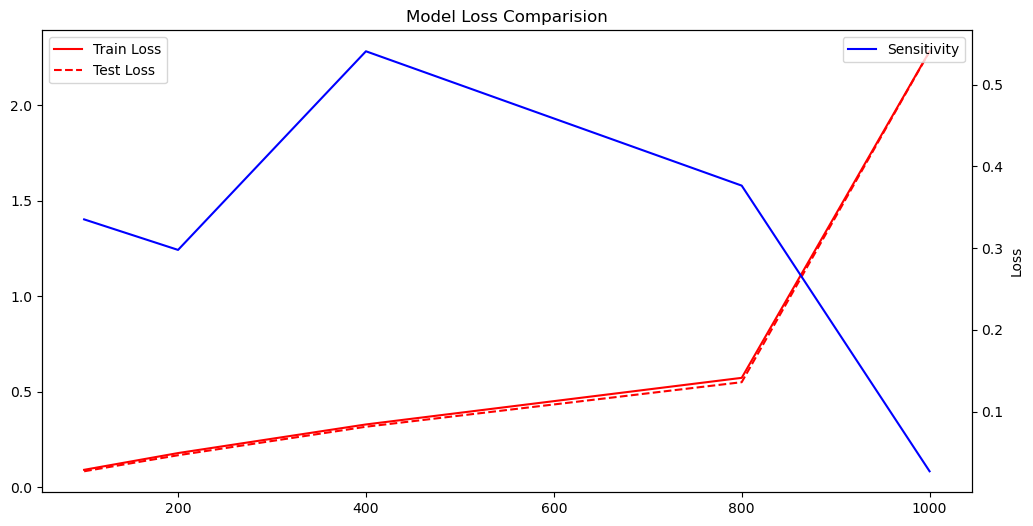

In [20]:
plt.figure(figsize=(12,6))
plt.plot(b_size, train_loss_array, color = "r")
plt.plot(b_size, test_loss_array, color = "r",linestyle="dashed")
plt.legend(['Train Loss', 'Test Loss'])
ax2 = plt.twinx()
plt.plot(b_size, senstivity_list, color = "b")
plt.title('Model Loss Comparision')
plt.legend(['Sensitivity'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

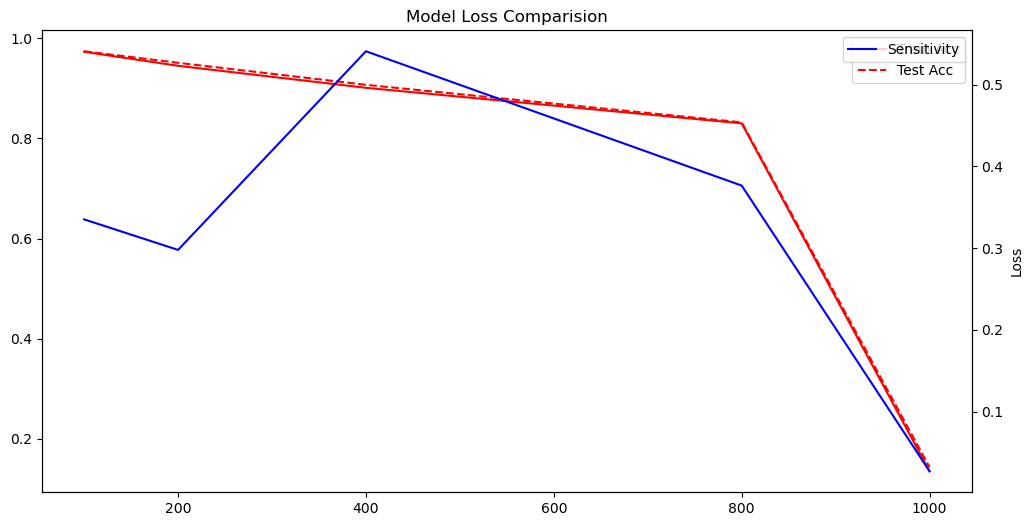

In [23]:
plt.figure(figsize=(12,6))
plt.plot(b_size, train_acc_list, color = "r")
plt.plot(b_size, test_acc_list, color = "r",linestyle="dashed")
plt.legend(['Train Acc', 'Test Acc'])
ax2 = plt.twinx()
plt.plot(b_size, senstivity_list, color = "b")
plt.title('Model Loss Comparision')
plt.legend(['Sensitivity'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()